In [89]:
import sys
import mss
import pandas as pd
import numpy as np

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

import seaborn as sns
import peakutils
import scipy
from scipy.integrate import simps

In [101]:
path = 'D:/UW/mssvalidation/20201119_ENTACT_validation_data/20201117_ENTACT_506_1.mzML'
scans = mss.mssmain.get_scans(path, ms_all=False, ms_lv=1)
#noise removal
mss.mssmain.noise_removal(scans, 2000)

In [64]:
#d_s1 = mss.mssmain.peak_list(scans, 20, enable_score=True)

In [102]:
d_md505 = pd.read_excel('D:/UW/mssvalidation/20201119_ENTACT_validation_data/20201117_ENTACT_msdial.xlsx',sheet_name='506')

In [103]:
d_s1 = pd.read_csv('D:/UW/mssvalidation/20201119_ENTACT_validation_data/506.csv')

In [104]:
d_mss = d_s1[['rt', 'm/z', 'peak area']]

In [105]:
d_msdial = d_md505[['RT (min)', 'Precursor m/z', 'Area']]

In [106]:
def batch_alignment(d_ref, d_align, rt_error=0.5, mz_error=0.01):
    #Alignment of new dataset
    result = []
    for row in np.arange(len(d_ref)):
        #Find overlap using the error range
        overlap = np.where((d_align.iloc[:, 0] - rt_error <=
                                        d_ref.iloc[row, 0]) & (d_ref.iloc[row, 0] <=
                                        d_align.iloc[:, 0] + rt_error) & (d_align.iloc[:, 1] - mz_error <=
                                        d_ref.iloc[row, 1]) & (d_ref.iloc[row, 1] <=
                                        d_align.iloc[:, 1] + mz_error))
        if len(overlap[0]) == 1:
            result.append([overlap[0][0], row])
        elif len(overlap[0]) > 1:
            dist = []
            for i in overlap[0]: # if multiple hits, use the closer feature for alignment
                dist.append(np.sqrt(((d_align.iloc[i, 0] - d_ref.iloc[row, 0])**2) +
                                    ((d_align.iloc[i, 1] - d_ref.iloc[row, 1])**2)))
            result.append([overlap[0][np.argmin(dist)], row])
        
    #Modeling using overlapping features except noises
#     align_index = [i[0] for i in result]
#     ref_index = [i[1] for i in result]
#     d_align = d_align.loc[align_index]
#     d_ref = d_ref.iloc[ref_index]

#     d_align.reset_index(drop=True,inplace=True)
#     d_ref.reset_index(drop=True,inplace=True)
#     d_join = d_align.iloc[:,3:] #Important !! -- The indexing is important especially reading other feedin data
#     d_merge = pd.concat([d_ref,d_join],axis=1)
        
    return result

In [107]:
d_xcms_raw = pd.read_excel('D:/UW/mssvalidation/20201119_ENTACT_validation_data/ENTACT506/results/XCMS-Report-SingleClass.xlsx')

In [108]:
d_xcms = d_xcms_raw[['rt', 'mz', 'into']].copy()
d_xcms['rt'] = d_xcms_raw['rt'] / 60

In [109]:
overlap_msd = batch_alignment(d_mss, d_msdial,rt_error = 0.5,mz_error=0.015)
overlap_xcms = batch_alignment(d_mss, d_xcms,rt_error = 0.5,mz_error=0.015)

In [110]:
mss_index_msd = [i[1] for i in overlap_msd]
mss_index_xcms = [i[1] for i in overlap_xcms]
msd_index = [i[0] for i in overlap_msd]
xcms_index = [i[0] for i in overlap_xcms]

In [115]:
d_xcms.shape

(16943, 3)

In [116]:
trip_overlap = batch_alignment(d_mss.iloc[mss_index_msd], d_xcms, rt_error=0.5, mz_error=0.015)
q_overlap = batch_alignment(d_msdial, d_xcms, rt_error=0.5, mz_error=0.015)

In [132]:
xcms_index_3 = [i[0] for i in q_overlap]
exclude_index = [i for i in xcms_index_3 if i not in xcms_index]

In [133]:
d_xcms.iloc[exclude_index]

,rt,mz,into
2094,0.566000,111.011447,2.258294e+05
2038,0.168167,248.968705,2.559444e+05
2056,0.549433,280.986882,1.416745e+04
2094,0.566000,111.011447,2.258294e+05
2103,0.333933,102.013075,1.194567e+07
...,...,...,...
16866,21.983200,275.958243,1.816462e+04
16935,22.115817,320.001618,8.057900e+04
16887,22.115817,243.986011,3.053494e+04
16913,22.165550,270.951815,3.836297e+04


(0, 10000000.0)

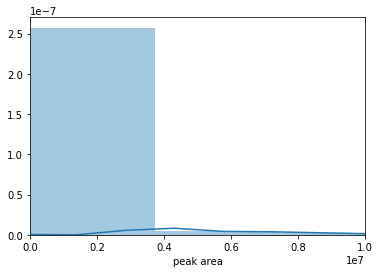

In [130]:
sns.distplot(d_mss.iloc[trip_index]['peak area'])
plt.xlim(0,1e7)

In [ ]:
sns.distplot(d_mss.iloc)

In [120]:
len(mss_index_xcms)

7692

Text(0.5, 1.0, 'retention time difference distribution')

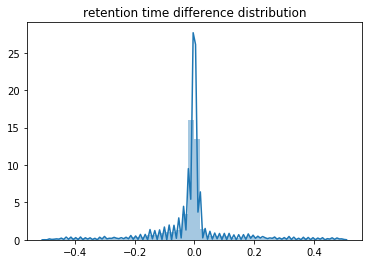

In [41]:
rtdist = list(list(d_mss.loc[mss_index]['rt']) - (d_msdial.loc[msd_index]['RT (min)']))
sns.distplot(rtdist)
plt.title('retention time difference distribution')

Text(0.5, 1.0, 'm/z difference distribution')

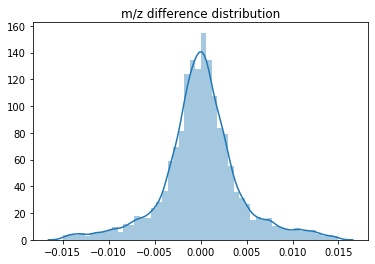

In [44]:
rtdist = list(list(d_mss.loc[mss_index]['m/z']) - (d_msdial.loc[msd_index]['Precursor m/z']))
sns.distplot(rtdist)
plt.title('m/z difference distribution')

Text(0.5, 1.0, 'Peak area difference distribution')

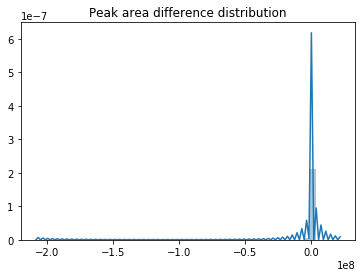

In [32]:
rtdist = list(list(d_mss.loc[mss_index]['peak area']) - (d_xcms.loc[xcms_index]['into']))
sns.distplot(rtdist)
plt.title('Peak area difference distribution')

In [155]:
d_msdial.shape[0]

2969

In [157]:
d_mss.shape[0]

1964

Text(0.5, 1.0, 'rt_error = 0.5, mz_error = 0.015 Da')

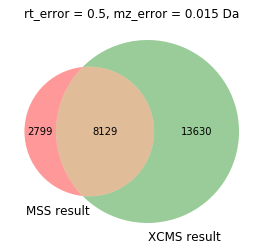

In [45]:
venn2(subsets = (2799, 13630, 8129), set_labels = ('MSS result', 'XCMS result'))
plt.title('rt_error = 0.5, mz_error = 0.015 Da')

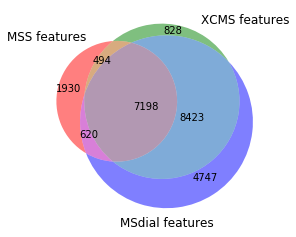

In [121]:
venn3(subsets = (1930,828,494,4747,620,8423,7198), set_labels = ('MSS features', 'XCMS features', 'MSdial features'), alpha = 0.5);

In [16]:
#distribution of mass error and rt error in aligned features
#summary of peak area in unique and overlapped ones
#score assessment

In [139]:
d_xcms.loc[xcms_index]

,rt,mz,into
1548,0.625317,105.963279,146502.933261
361,0.625317,107.960023,120927.914696
312,0.625317,110.008953,470878.259287
2019,0.675067,111.010860,15122.851232
1317,0.675067,112.006249,17726.079376
...,...,...,...
5822,21.106733,165.052680,98682.191621
5819,21.139900,127.959653,191276.798619
5813,21.106733,133.026363,54454.330364
5808,21.090150,107.029921,216122.826739


Text(0.5, 1.0, 'overlap scoring')

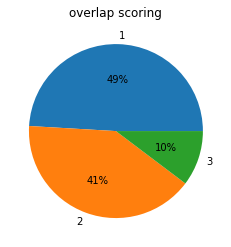

In [49]:
plt.pie(d_s1.loc[mss_index]['score'].value_counts(),labels=list(set(d_s1['score'])), autopct='%1.0f%%');
plt.title('overlap scoring')
#plt.xticks([1,2,3])

In [102]:
d_xcms.shape

(5827, 3)

Text(0.5, 1.0, 'unique features scoring')

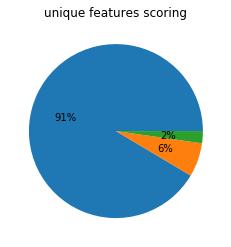

In [48]:
plt.pie(d_s1.loc[[i for i in d_s1.index if i not in mss_index]]['score'].value_counts(), autopct='%1.0f%%');
plt.title('unique features scoring')

In [44]:
d_msdial.loc[[i for i in d_msdial.index if i not in msd_index]]

,RT(min),Precursor m/z,Area
0,0.59215,105.9635,233135.70
1,0.59215,107.9599,132922.30
2,0.59215,110.0088,521536.60
3,0.59215,111.0117,82580.55
4,0.59215,112.0069,75445.54
...,...,...,...
2964,21.20623,141.9593,15008850.00
2965,21.20623,182.9832,728052.60
2966,21.27257,128.9878,644385.40
2967,21.28915,113.9649,1128074.00


In [63]:
d_mss

,rt,m/z,peak area
0,3.97,100.0113,160580.431315
1,3.06,100.0733,24689.075602
2,2.08,100.0753,53319.403320
3,2.68,100.1073,19946.666463
4,0.84,100.1113,219598.429525
...,...,...,...
10923,19.59,1679.4716,28597.217855
10924,19.57,1680.4796,13778.617269
10925,20.15,1680.4796,15459.764791
10926,20.22,1681.4545,12127.953857


In [97]:
test_dict = {1:1,2:2,3:3}
import itertools 
dict(itertools.islice(test_dict.items(), 1))  

{1: 1}

In [94]:
peak_pick(scans,299.1765,50)

{672: [664, 679, 393229.9112955729, 0, 1]}

In [136]:
d_xcms.iloc[exclude_index].iloc[3000:3200]

,rt,mz,into
6502,7.760367,395.138132,32772.443676
6510,7.760367,465.953522,15142.679954
6538,7.760367,471.222196,124869.898506
6485,7.760367,472.225516,23902.866222
6539,7.760367,484.139372,47420.893985
...,...,...,...
409,8.009017,693.184732,23638.069747
6819,8.009017,703.081262,32270.227104
6793,8.009017,708.348610,12749.728072
1349,7.992433,909.400040,49841.495182


484.139


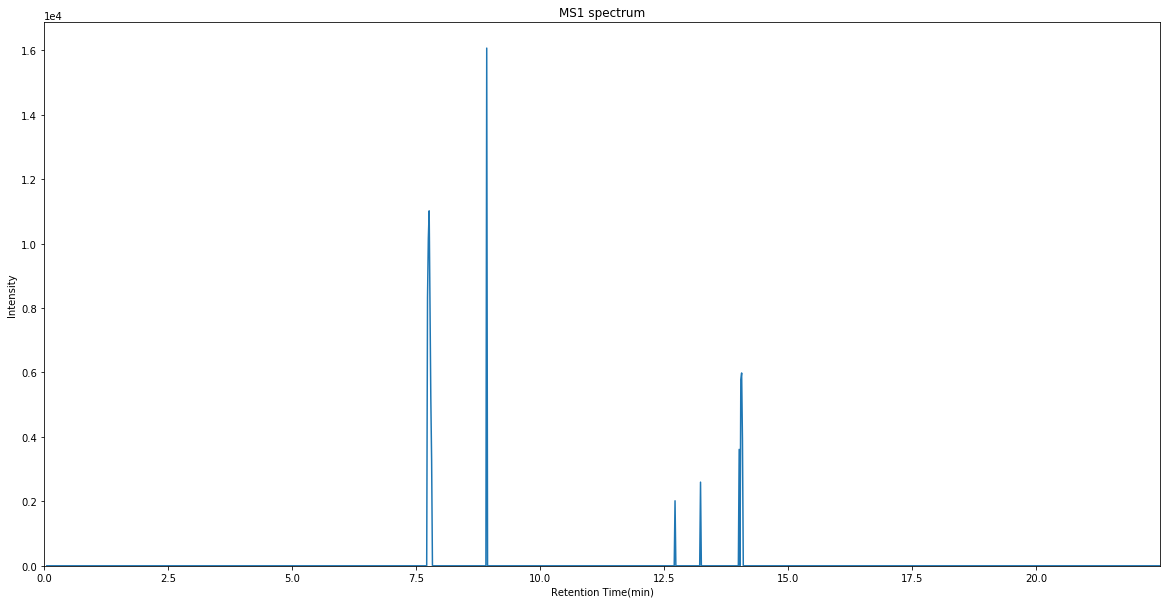

In [139]:
mss.visreader.ms_chromatogram(scans, 484.1393, 10,interactive=False)